<a href="https://colab.research.google.com/github/TarikSalles/TensorFlow-Advanced-Techniques-Specialization/blob/main/Gerador%20de%20Face%20de%20Cachorros%20com%20GAN%20simples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GAN simples para criação de faces de cachorros

## Imports

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from zipfile import ZipFile
import cv2


## Funções Uteis

In [ ]:
def plot_multiple_images_tf(X_train, ammount_images, n_cols=None):

    random_indices = np.random.choice(X_train.shape[0], ammount_images, replace=False)

    random_indices = tf.convert_to_tensor(random_indices, dtype=tf.int32)

    images = tf.gather(X_train, random_indices)

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for index, image_tensor in enumerate(images):
        image = image_tensor.numpy()
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

    plt.show()


In [ ]:
def load_and_preprocess_images(target_size=(128, 128)):

    train_dir = '/content/dogs/data/train/dogs'

    X_train = []

    for image_name in os.listdir(train_dir):
        image_path = os.path.join(train_dir, image_name)

        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)

        img = img.astype(np.float32) / 255
        X_train.append(img)

    X_train = np.array(X_train)
    X_train = tf.stack(X_train)
    return X_train


# Load and preprocess images
X_train = load_and_preprocess_images()


In [ ]:
len(X_train)

5118

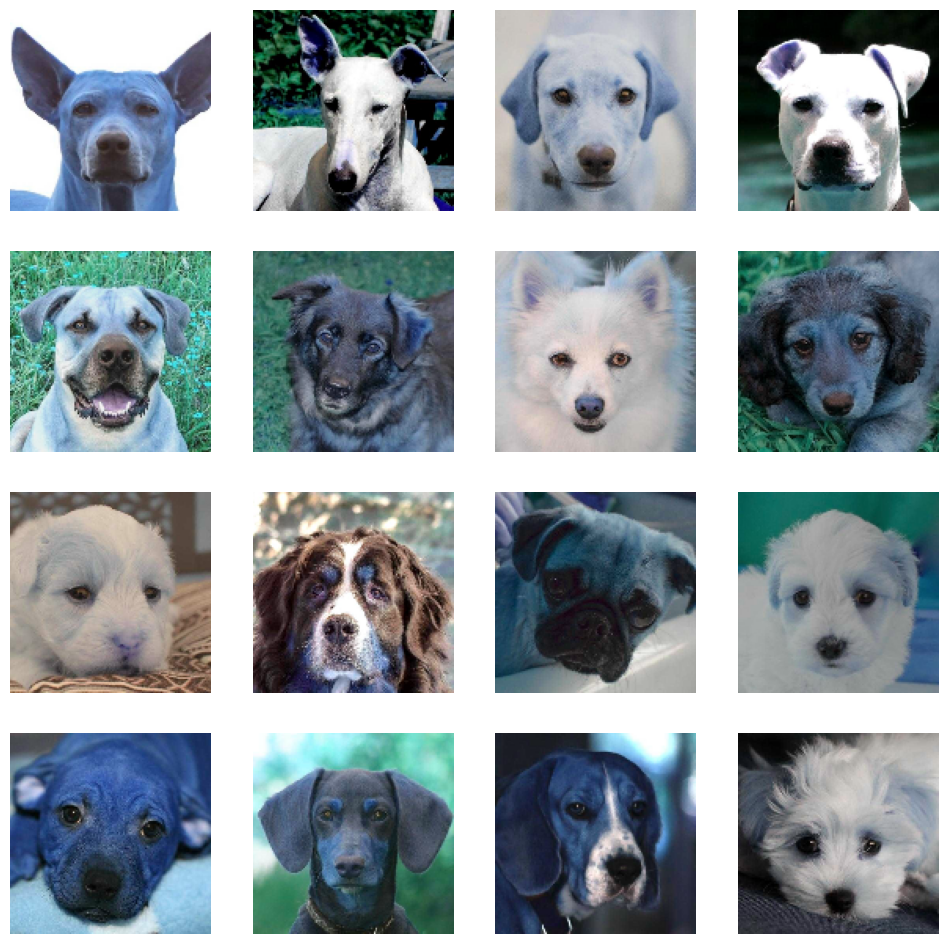

In [ ]:
plot_multiple_images_tf(X_train,16, n_cols=4)

In [ ]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

### Gerador

In [ ]:
random_normal_dimensions = 256

generator = keras.models.Sequential([
    keras.layers.Dense(64, activation="selu", input_shape=[random_normal_dimensions]),
    keras.layers.Dense(128, activation="selu"),
    keras.layers.Dense(256, activation="selu"),
    keras.layers.Dense(512, activation="selu"),
    keras.layers.Dense(128 * 128 * 3, activation="sigmoid"),
    keras.layers.Reshape([128, 128,3])
])

### Passando barulho para gerador

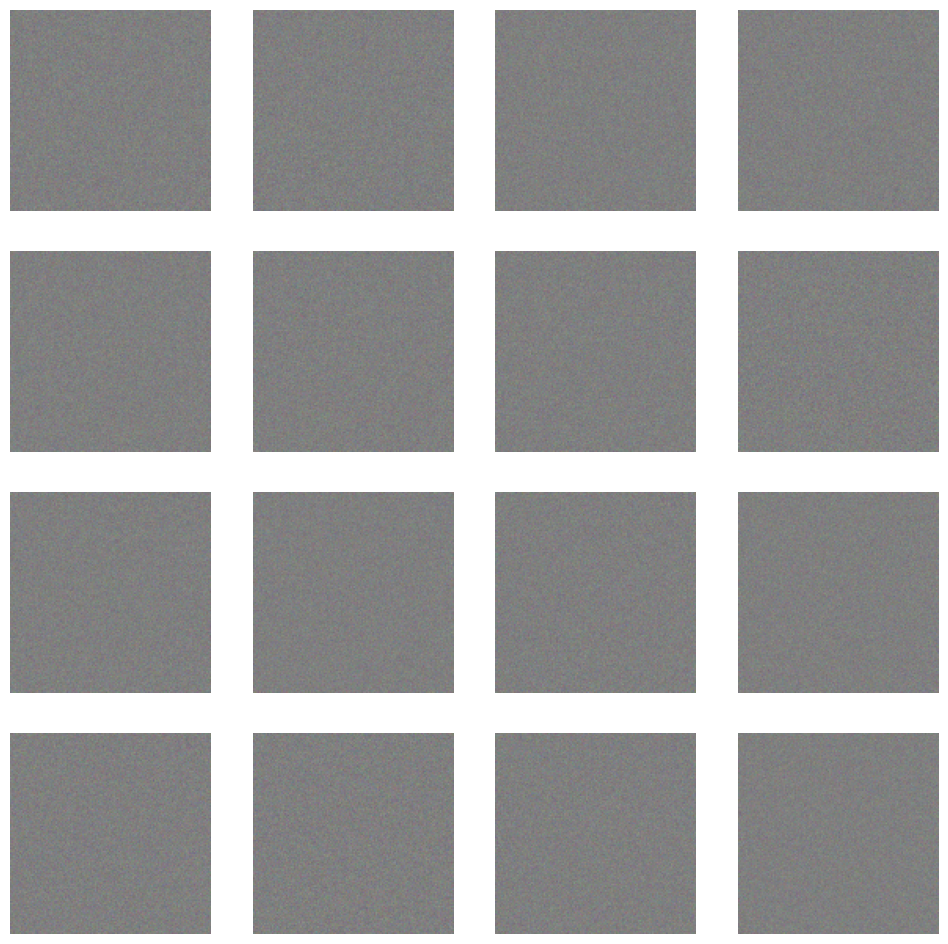

In [ ]:
test_noise = tf.random.normal([16, random_normal_dimensions])

test_image = generator(test_noise)

plot_multiple_images_tf(test_image, 16, n_cols=4)

### Discriminador

In [ ]:
discriminator = keras.models.Sequential([
    keras.Input(shape=(128, 128,3)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="selu"),
    keras.layers.Dense(256, activation="selu"),
    keras.layers.Dense(128, activation="selu"),
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Treinando o modelo


* Fase 1 - treina o discriminador com dados reais e falsos
* Fase 2 - treina o gerador



In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):


    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Época {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:
            batch_size = real_images.shape[0]

            # Fase 1
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            fake_images = generator(noise)

            mixed_images = tf.concat([fake_images, real_images], axis=0)

            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            discriminator.trainable = True

            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Fase 2
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            generator_labels = tf.constant([[1.]] * batch_size)

            discriminator.trainable = False

            gan.train_on_batch(noise, generator_labels)
        if epoch == n_epochs - 1:
          plot_multiple_images_tf(fake_images, 8)
          plt.show()

Época 1/50
Época 2/50
Época 3/50
Época 4/50
Época 5/50
Época 6/50
Época 7/50
Época 8/50
Época 9/50
Época 10/50
Época 11/50
Época 12/50
Época 13/50
Época 14/50
Época 15/50
Época 16/50
Época 17/50
Época 18/50
Época 19/50
Época 20/50
Época 21/50
Época 22/50
Época 23/50
Época 24/50
Época 25/50
Época 26/50
Época 27/50
Época 28/50
Época 29/50
Época 30/50
Época 31/50
Época 32/50
Época 33/50
Época 34/50
Época 35/50
Época 36/50
Época 37/50
Época 38/50
Época 39/50
Época 40/50
Época 41/50
Época 42/50
Época 43/50
Época 44/50
Época 45/50
Época 46/50
Época 47/50
Época 48/50
Época 49/50
Época 50/50


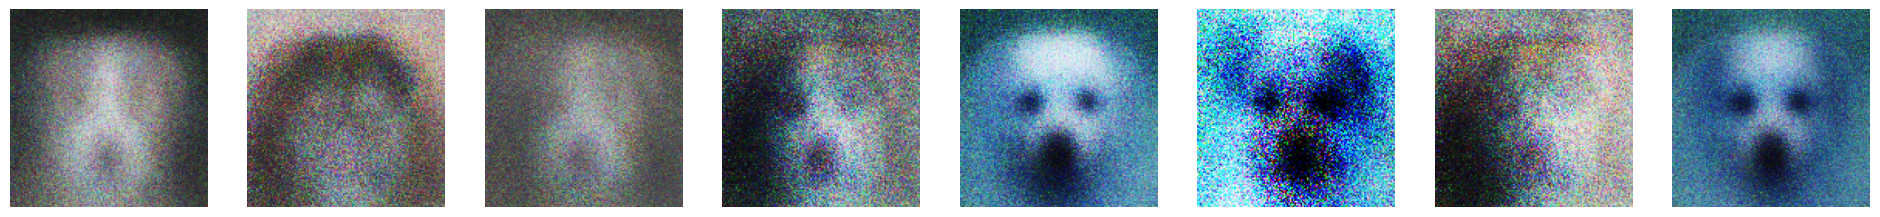

In [ ]:
train_gan(gan, dataset, random_normal_dimensions, n_epochs=50)

### Com uma GAN muito simples é notório que acabou se tornando "enbiesada" e suas saídas se parecem muito, com 3 cachorros que parecem se repetir continuamente, talvez pela simplicidade de suas características, ou por um barulho parecido